**3.6.** The file m sp500ret 3mtcm.txt contains three columns. The second column gives the monthly returns of the S&P 500 index from January 1994 to December 2006. The third column gives the monthly rates of the 3-month U. S. Treasury bill in the secondary market, which is obtained from the Federal Reserve Bank of St. Louis and used as the risk-free asset here. Consider the ten monthly returns in the file m ret 10stocks.txt.

**Pre data cleaning**

In [ ]:
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import f, t
import pandas as pd
import numpy as np

In [3]:
# Load and format data
df_market = pd.read_csv('m_sp500ret_3mtcm.csv')
log_returns = pd.read_csv('ret-10-stocks.csv')
log_returns['Date'] = pd.to_datetime(log_returns['Date'])

In [4]:
stock_names = log_returns.columns[1:]

# Create empty dataset to store normal returns
stocks_ret = pd.DataFrame()

# Compute normal returns for each ticker
for stock in stock_names:
    stocks_ret[stock] = log_returns[stock].apply(lambda x: np.exp(x) - 1)

# Merge the two datasets
data = pd.concat([df_market[['sp500', '3mTCM']], stocks_ret], axis=1)

num_obs = len(data)
data.index = pd.date_range(start='1994-01-01', periods=num_obs, freq='MS')

# Cast treasury bill rates to decimal instead of percentage
data['3mTCM'] /= 100 

# Market excess return (MER)
data['MER'] = data['sp500'] - data['3mTCM']

data.head()

,sp500,3mTCM,AAPL,ADBE,ADP,AMD,DELL,GTW,HP,IBM,MSFT,ORCL,MER
1994-01-01,0.013890,0.0298,0.050129,0.144829,-0.022636,0.064293,-0.012510,0.093338,-0.004323,0.000000,0.023759,0.050335,-0.015910
1994-02-01,-0.013248,0.0325,0.050061,-0.014823,-0.009462,0.020900,0.061397,-0.002164,-0.014283,-0.026493,-0.013451,0.010849,-0.045748
1994-03-01,-0.020336,0.0350,-0.039941,-0.075894,0.000873,0.176181,0.000000,-0.068942,-0.007917,0.014270,0.011702,-0.010732,-0.055336
1994-04-01,0.004979,0.0368,-0.043423,0.042837,0.002177,-0.070805,-0.057845,-0.111203,0.002288,0.022545,0.039174,-0.030656,-0.031821
1994-05-01,0.005351,0.0414,-0.009526,0.032403,0.015888,0.010140,0.129453,-0.018123,0.003412,0.042293,0.067096,0.059318,-0.036049


In [5]:
# Calculate stock excess returns
names_e = []

for name in stock_names:
    excess_name = f'{name}_e'
    data[excess_name] = data[name] - data['3mTCM']
    names_e.append(excess_name)

(a). Fit CAPM to the ten stocks. Give point estimates and 95% confidence intervals of $\alpha$, $\beta$, the Sharpe index, and the Treynor index (Hint: Use the delta method for the Sharpe and Treynor indices.)

In [7]:
# Constants
ALPHA_LEVEL = 0.05   # 95% confidence interval

In [8]:
def fit_capm(df, e_names, market_er):
    '''
    Fit CAPM. Give point estimates and 95% CIs for alpha, beta.
    Sharpe ratio, and Treynor index.
    '''

    models = []
    alphas = []

    for e_name in e_names:
        print(f'Analysis for: {e_name}')
        Y = df[e_name]
        X = sm.add_constant(market_er)
        n = len(Y)

        # Fit OLS model
        model = sm.OLS(Y, X).fit()
        models.append(model)

        # Alpha, Beta estimates & CIs
        alpha_h = model.params['const']
        beta_h = model.params['MER']
        alphas.append(alpha_h)
        alpha_ci = model.conf_int(ALPHA_LEVEL).loc['const'].values
        beta_ci = model.conf_int(ALPHA_LEVEL).loc['MER'].values

        # Sharpe Ratio
        mu_e_h = Y.mean()
        sigma_e_h = Y.std(ddof=1)
        sharpe_h = mu_e_h / sigma_e_h

        # Sharpe CI (Delta Method, Var(S) ~ (1 + 0.5*S^2)/n)
        se_sharpe = np.sqrt((1 + 0.5 * sharpe_h**2) / n)
        z_crit = t.ppf(1 - ALPHA_LEVEL / 2, n - 1)
        sharpe_ci = [sharpe_h - z_crit * se_sharpe, sharpe_h + z_crit * se_sharpe]

        # Treynor Ratio
        mu_EMR_hat = market_er.mean()
        treynor_h = mu_e_h + alpha_h / beta_h

        # Treynor CI (Delta Method)
        grad_g = np.array([1 / beta_h, - alpha_h / (beta_h**2)])
        cov_ab = model.cov_params().loc[['const', 'MER'], ['const', 'MER']].values
        var_treynor = grad_g.T @ cov_ab @ grad_g
        se_treynor = np.sqrt(var_treynor)
        treynor_ci = [treynor_h - z_crit * se_treynor, treynor_h + z_crit * se_treynor]

        print(f"Alpha   : {alpha_h:9.6f}, CI: [{alpha_ci[0]:9.6f}, {alpha_ci[1]:9.6f}]")
        print(f"Beta    : {beta_h:9.6f}, CI: [{beta_ci[0]:9.6f}, {beta_ci[1]:9.6f}]")
        print(f"Sharpe  : {sharpe_h:9.6f}, CI: [{sharpe_ci[0]:9.6f}, {sharpe_ci[1]:9.6f}]")
        print(f"Treynor : {treynor_h:9.6f}, CI: [{treynor_ci[0]:9.6f}, {treynor_ci[1]:9.6f}]")

    return models, alphas

In [9]:
results_a = fit_capm(data, names_e, data['MER'])

Analysis for: AAPL_e
Alpha   :  0.021970, CI: [ 0.004322,  0.039617]
Beta    :  1.447559, CI: [ 1.032207,  1.862911]
Sharpe  : -0.425037, CI: [-0.590183, -0.259891]
Treynor : -0.014363, CI: [-0.023231, -0.005494]
Analysis for: ADBE_e
Alpha   :  0.018576, CI: [ 0.000712,  0.036439]
Beta    :  1.329802, CI: [ 0.909368,  1.750235]
Sharpe  : -0.417337, CI: [-0.582238, -0.252437]
Treynor : -0.014775, CI: [-0.024804, -0.004746]
Analysis for: ADP_e
Alpha   : -0.004426, CI: [-0.011235,  0.002383]
Beta    :  0.841128, CI: [ 0.680876,  1.001381]
Sharpe  : -1.124404, CI: [-1.326459, -0.922350]
Treynor : -0.039618, CI: [-0.048569, -0.030667]
Analysis for: AMD_e
Alpha   :  0.034373, CI: [ 0.012524,  0.056222]
Beta    :  1.888061, CI: [ 1.373819,  2.402302]
Sharpe  : -0.376489, CI: [-0.540155, -0.212823]
Treynor : -0.014606, CI: [-0.022504, -0.006708]
Analysis for: DELL_e
Alpha   :  0.021826, CI: [ 0.006433,  0.037220]
Beta    :  1.314299, CI: [ 0.951991,  1.676607]
Sharpe  : -0.407432, CI: [-0.5720

Use the bootstrap procedure in Section 3.5 to estimate the standard errors of the point estimates of $\alpha$, $\beta$, and the Sharpe and Treynor indices.

In [12]:
# Number of boostrap samples
NUM_BOOTSTRAP = 1000

In [13]:
def bootstrap(df, e_names, market_er):
    '''
    Bootstrap procedure to estimate standard errors of 
    alpha, beta, Sharpe, and Treynor.
    '''
    
    for e_name in e_names:
        print(f"\nAnalysis for: {e_name}")
        
        Y = df[e_name]
        n = len(Y)

        boot_alphas = []
        boot_betas = []
        boot_sharpes = []
        boot_treynors = []
        
        Y_np = Y.values
        MER_np = market_er.values
        
        for _ in range(NUM_BOOTSTRAP):
            indices = np.random.choice(range(n), n, replace=True)
            Y_boot = Y_np[indices]
            MER_boot_series = MER_np[indices]
            X_boot = sm.add_constant(MER_boot_series)
            
            try:
                model_boot = sm.OLS(Y_boot, X_boot).fit()
                a_boot = model_boot.params[0]
                b_boot = model_boot.params[1]
                s_boot = Y_boot.mean() / Y_boot.std(ddof=1)
                t_boot = a_boot / b_boot + MER_boot_series.mean()
                
                if np.isfinite([a_boot, b_boot, s_boot, t_boot]).all():
                    boot_alphas.append(a_boot)
                    boot_betas.append(b_boot)
                    boot_sharpes.append(s_boot)
                    boot_treynors.append(t_boot)
            except Exception:
                continue 

        print(f"SE(Alpha)  : {np.std(boot_alphas, ddof=1):9.6f}")
        print(f"SE(Beta)   : {np.std(boot_betas, ddof=1):9.6f}")
        print(f"SE(Sharpe) : {np.std(boot_sharpes, ddof=1):9.6f}")
        print(f"SE(Treynor): {np.std(boot_treynors, ddof=1):9.6f}")

In [14]:
std_errors = bootstrap(data, names_e, data['MER'])


Analysis for: AAPL_e
SE(Alpha)  :  0.008279
SE(Beta)   :  0.245754
SE(Sharpe) :  0.079136
SE(Treynor):  0.004374

Analysis for: ADBE_e
SE(Alpha)  :  0.007110
SE(Beta)   :  0.220743
SE(Sharpe) :  0.082240
SE(Treynor):  0.004349

Analysis for: ADP_e
SE(Alpha)  :  0.003738
SE(Beta)   :  0.096360
SE(Sharpe) :  0.121051
SE(Treynor):  0.005972

Analysis for: AMD_e
SE(Alpha)  :  0.010257
SE(Beta)   :  0.276117
SE(Sharpe) :  0.089717
SE(Treynor):  0.004473

Analysis for: DELL_e
SE(Alpha)  :  0.007049
SE(Beta)   :  0.181996
SE(Sharpe) :  0.083653
SE(Treynor):  0.003983

Analysis for: GTW_e
SE(Alpha)  :  0.011331
SE(Beta)   :  0.307600
SE(Sharpe) :  0.085870
SE(Treynor):  0.005636

Analysis for: HP_e
SE(Alpha)  :  0.006203
SE(Beta)   :  0.151080
SE(Sharpe) :  0.091605
SE(Treynor):  0.007231

Analysis for: IBM_e
SE(Alpha)  :  0.004453
SE(Beta)   :  0.103675
SE(Sharpe) :  0.095666
SE(Treynor):  0.003859

Analysis for: MSFT_e
SE(Alpha)  :  0.004868
SE(Beta)   :  0.124456
SE(Sharpe) :  0.086369
SE(

(c). Test for each stock the null hypothesis $\alpha = 0$.

In [17]:
def hyp_test(models, e_names):
    """
    Test for each stock the null hypothesis alpha = 0.
    (This function re-uses the models fitted in part_a)
    """
    
    for i, model in enumerate(models):
        e_name = e_names[i]
        alpha_t_stat = model.tvalues['const']
        alpha_p_value = model.pvalues['const']

        print(f"\nAnalysis for: {e_name}")
        print(f"t-statistic: {alpha_t_stat:9.6f}, p-value: {alpha_p_value:9.6f}")


In [18]:
hyp_test(results_a[0], names_e)


Analysis for: AAPL_e
t-statistic:  2.459323, p-value:  0.015027

Analysis for: ADBE_e
t-statistic:  2.054245, p-value:  0.041642

Analysis for: ADP_e
t-statistic: -1.284116, p-value:  0.201030

Analysis for: AMD_e
t-statistic:  3.107809, p-value:  0.002245

Analysis for: DELL_e
t-statistic:  2.800978, p-value:  0.005749

Analysis for: GTW_e
t-statistic:  2.078695, p-value:  0.039304

Analysis for: HP_e
t-statistic:  0.206550, p-value:  0.836634

Analysis for: IBM_e
t-statistic:  1.875858, p-value:  0.062567

Analysis for: MSFT_e
t-statistic:  2.339847, p-value:  0.020575

Analysis for: ORCL_e
t-statistic:  1.730178, p-value:  0.085602


(d). Use the regression model (3.24) to test for the ten stocks the null hypothesis $\alpha = 0$.

In [19]:
def grs_test(models, alphas, df, e_names, market_er):
    """
    Perform the Gibbons Ross Shanken test for H0: all alphas = 0.
    (This function re-uses models and alphas from part a)
    """
    
    T = len(df)                  # Number of time periods
    N = len(e_names)       # Number of assets (10)
    
    # Get T x N matrix of residuals
    res_matrix = np.empty((T, N))
    for i, model in enumerate(models):
        res_matrix[:, i] = model.resid # Residuals are just yt - α - xtβ
        
    # Get N x N covariance matrix of residuals (MLE, ddof=0)
    Sigma_hat = np.cov(res_matrix, rowvar=False, ddof=0)
    
    # Get N x 1 vector of estimated alphas
    alphas_hat_vec = np.array(alphas)
    
    # Get market mean and variance
    mu_M_e_hat = market_er.mean()
    var_M_e_hat = market_er.var(ddof=0) # MLE variance
    
    # Calculate squared market Sharpe ratio
    sharpe_M_sq = (mu_M_e_hat**2) / var_M_e_hat
    
    # Calculate the GRS statistic
    try:
        Sigma_hat_inv = np.linalg.inv(Sigma_hat)
    except np.linalg.LinAlgError:
        print("Error: Residual covariance matrix is singular. Cannot perform GRS test.")
        return
        
    quadratic_form = alphas_hat_vec.T @ Sigma_hat_inv @ alphas_hat_vec
    
    GRS_stat = ((T - N - 1) / N) * (quadratic_form / (1 + sharpe_M_sq))
    
    # Calculate p-value from F-distribution
    p_value = 1.0 - f.cdf(GRS_stat, N, T - N - 1)
    
    print(f"GRS F-statistic: {GRS_stat:9.6f}")
    print(f"Numerator df   : {N}")
    print(f"Denominator df : {T - N - 1}")
    print(f"p-value        : {p_value:9.6f}")

In [20]:
grs_test(results_a[0], results_a[1], data, names_e, data['MER'])

GRS F-statistic:  1.971990
Numerator df   : 10
Denominator df : 145
p-value        :  0.040383


(e) Perform a factor analysis on the excess returns of the ten stocks. Show the factor loadings and rotated factor loadings. Explain your choice of the number of factors.


Choosing Number of Factors (k) via PCA Eigenvalues:
[4.27445255 1.06119509 0.89428186 0.82898217 0.76909078 0.63918001
 0.4974481  0.44545336 0.34351647 0.31091573]
Kaiser Criterion (eigenvalues > 1) suggests k = 2 factors.


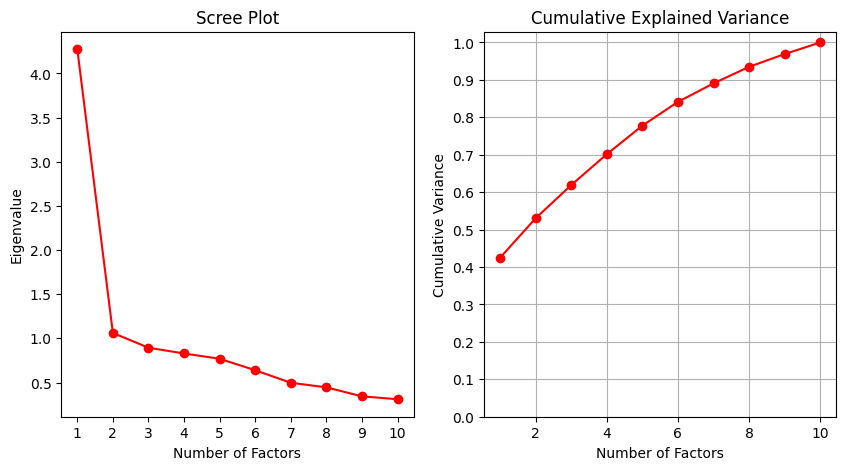

We will proceed with k = 2.

Unrotated Factor Loadings:
        Factor_1  Factor_2
AAPL_e   -0.6023    0.3537
ADBE_e   -0.4245    0.3215
ADP_e    -0.4561    0.1643
AMD_e    -0.5844    0.3618
DELL_e   -0.7516    0.0280
GTW_e    -0.5953    0.2115
HP_e     -0.3065    0.3624
IBM_e    -0.7055    0.1084
MSFT_e   -0.8397   -0.3550
ORCL_e   -0.4802    0.1322

Rotated (Varimax) Factor Loadings:
        Factor_1  Factor_2
AAPL_e   -0.3454    0.6071
ADBE_e   -0.2074    0.4905
ADP_e    -0.3133    0.3700
AMD_e    -0.3259    0.6052
DELL_e   -0.6373    0.3994
GTW_e    -0.4103    0.4803
HP_e     -0.0848    0.4670
IBM_e    -0.5572    0.4460
MSFT_e   -0.9049    0.1115
ORCL_e   -0.3501    0.3543


In [21]:
def factor_analysis(df, e_names):
    """
    Perform factor analysis on the 10 excess returns.
    """
    Y_excess = df[e_names]
    Y_scaled = StandardScaler().fit_transform(Y_excess)
    
    # Choose number of factors (k)
    pca = PCA()
    pca.fit(Y_scaled)
    eigenv = pca.explained_variance_
    
    print("\nChoosing Number of Factors (k) via PCA Eigenvalues:")
    print(eigenv)
    
    k_kaiser = np.sum(eigenv > 1)
    print(f"Kaiser Criterion (eigenvalues > 1) suggests k = {k_kaiser} factors.")
    
    # Plot Scree Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 11), eigenv, 'o-', color='red')
    plt.title('Scree Plot')
    plt.xlabel('Number of Factors')
    plt.ylabel('Eigenvalue')
    plt.xticks(range(1, 11))

    plt.subplot(1, 2, 2)
    plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), 'o-', color='red')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Factors')
    plt.ylabel('Cumulative Variance')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(True)
    plt.show(block=False) # Show plot without stopping script
    
    print(f"We will proceed with k = {k_kaiser}.")
    k = k_kaiser
    if k == 0:
        print("No factors found with eigenvalue > 1. Defaulting to k=1.")
        k = 1
        
    # --- Fit Factor Analysis ---
    fa_unrotated = FactorAnalysis(n_components=k, rotation=None, random_state=42).fit(Y_scaled)
    loadings_unrotated = pd.DataFrame(
        fa_unrotated.components_.T, 
        index=e_names,
        columns=[f'Factor_{i+1}' for i in range(k)]
    )
    print("\nUnrotated Factor Loadings:")
    print(loadings_unrotated.to_string(float_format="%.4f"))
    
    fa_rotated = FactorAnalysis(n_components=k, rotation='varimax', random_state=42).fit(Y_scaled)
    loadings_rotated = pd.DataFrame(
        fa_rotated.components_.T, 
        index=e_names,
        columns=[f'Factor_{i+1}' for i in range(k)]
    )
    print("\nRotated (Varimax) Factor Loadings:")
    print(loadings_rotated.to_string(float_format="%.4f"))

factor_analysis(data, names_e)


(f) Consider the model

$$
r^{e}_{t} = \beta _1 \mathbb{1}_{t < t_0}r^{e}_{M} + \beta _2 \mathbb{1}_{t \geq t_0}r^{e}_{M} + \epsilon_t
$$

in which $r^{e}_t=r_t-r_f$ and $r^{e}_M=r_M-r_f$ are the excess returns of the stock and the SP500 index. The model suggests that the $\beta$ in the CAPM might not be a constant (i.e., $\beta _1 \neq \beta _2$). Taking February 2001 as the month $t_0$, test for each stock the null hypothesis that $\beta _1 = \beta _2$.

In [22]:
# Data starts Jan 1994. 
# (2001 - 1994) * 12 + (Feb - Jan) = 7 * 12 + 1 = 85
# This is the 85th data point (index 84 because 0-indexed)
BREAKPOINT = 84

In [23]:
data.iloc[84]

sp500     0.014788
3mTCM     0.051500
AAPL      0.176157
ADBE     -0.116963
ADP      -0.023965
AMD       0.284978
DELL      0.191755
GTW       0.074788
HP        0.037967
IBM       0.127262
MSFT      0.159964
ORCL      0.000896
MER      -0.036712
AAPL_e    0.124657
ADBE_e   -0.168463
ADP_e    -0.075465
AMD_e     0.233478
DELL_e    0.140255
GTW_e     0.023288
HP_e     -0.013533
IBM_e     0.075762
MSFT_e    0.108464
ORCL_e   -0.050604
Name: 2001-01-01 00:00:00, dtype: float64

In [25]:
def capm_model_betas(df, e_name, market_er):
    """
    Test H0: beta1 = beta2 in the no-intercept model with a break at Feb 2001.
    Model: r_t^e = beta1 * 1(t<t0) * MER + beta2 * 1(t>=t0) * MER + epsilon
    """
    for stock_name in e_name:
        print(f"\nTest H0: beta1 = beta2 for {stock_name}")
        
        Y = df[stock_name]
        n = len(Y)
        
        # Create the two regressors for the unrestricted model
        X1 = np.zeros(n)
        X2 = np.zeros(n)
        
        X1[:BREAKPOINT] = market_er.iloc[:BREAKPOINT]
        X2[BREAKPOINT:] = market_er.iloc[BREAKPOINT:]
        
        X_unrestricted = pd.DataFrame({'X1_beta1': X1, 'X2_beta2': X2}, index=df.index)
        
        # Fit unrestricted model (no intercept): Y = b1*X1 + b2*X2
        model_unrestricted = sm.OLS(Y, X_unrestricted).fit()
        rss_u = model_unrestricted.ssr
        k_u = 2 # Number of parameters
        
        # Create the regressor for the restricted model (H0: b1 = b2 = b)
        # Model: Y = b * (X1 + X2) = b * MER
        X_restricted = market_er
        
        # Fit restricted model (no intercept)
        model_restricted = sm.OLS(Y, X_restricted).fit()
        rss_r = model_restricted.ssr
        k_r = 1 # Number of parameters
        
        # Calculate F-statistic
        q = k_u - k_r # Number of restrictions
        
        F_stat = ((rss_r - rss_u) / q) / (rss_u / (n - k_u))
        p_value = 1.0 - f.cdf(F_stat, q, n - k_u)
        
        print(f"F-statistic: {F_stat:9.6f} (df_num={q}, df_den={n - k_u})")
        print(f"p-value    : {p_value:9.6f}")
        if p_value < 0.05:
            print("Result: Reject H0. The betas are likely different (p < 0.05).")
        else:
            print("Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).")

In [26]:
capm_model_betas(data, names_e, data['MER'])


Test H0: beta1 = beta2 for AAPL_e
F-statistic:  2.122474 (df_num=1, df_den=154)
p-value    :  0.147188
Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).

Test H0: beta1 = beta2 for ADBE_e
F-statistic:  2.096994 (df_num=1, df_den=154)
p-value    :  0.149622
Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).

Test H0: beta1 = beta2 for ADP_e
F-statistic:  2.105004 (df_num=1, df_den=154)
p-value    :  0.148852
Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).

Test H0: beta1 = beta2 for AMD_e
F-statistic:  1.492320 (df_num=1, df_den=154)
p-value    :  0.223724
Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).

Test H0: beta1 = beta2 for DELL_e
F-statistic:  0.523597 (df_num=1, df_den=154)
p-value    :  0.470409
Result: Fail to reject H0. No strong evidence of a break (p >= 0.05).

Test H0: beta1 = beta2 for GTW_e
F-statistic:  6.959195 (df_num=1, df_den=154)
p-value    :  0.009195
Result: Reject H0. The betas 

(g). Estimate $t_0$ in (f) by the least squares criterion that minimizes the residual sum of squares over $(\beta _1, \beta _2, t_0)$

In [27]:
def least_squares_t0(df, e_names, market_er):
    """
    Estimates t0 by minimizing RSS for the model in (f).
    """
    
    for e_name in e_names:
        print(f"\nAnalysis for: {e_name}")

        Y = df[e_name]
        n = len(Y)
        
        # Set trim to 15% (common practice)
        trim = int(0.15 * n)
        possible_t0s = range(trim, n - trim)
        rss_values = []
        
        for t0_idx in possible_t0s:
            X1 = np.zeros(n)
            X2 = np.zeros(n)
            X1[:t0_idx] = market_er.iloc[:t0_idx]
            X2[t0_idx:] = market_er.iloc[t0_idx:]
            X_g = pd.DataFrame({'X1': X1, 'X2': X2}, index=df.index)
            
            model_g = sm.OLS(Y, X_g).fit()
            rss_values.append(model_g.ssr)
            
        # Find the index that minimizes RSS
        min_rss_internal_idx = np.argmin(rss_values)
        best_t0_index = possible_t0s[min_rss_internal_idx]
        best_t0_date = df.index[best_t0_index]
        
        print(f"Optimal breakpoint t0 found at index: {best_t0_index}")
        print(f"This corresponds to the date: {best_t0_date.strftime('%Y-%m')}")
        print(f"Minimum RSS at this break : {min(rss_values):.6f}")

In [28]:
least_squares_t0(data, names_e, data['MER'])


Analysis for: AAPL_e
Optimal breakpoint t0 found at index: 84
This corresponds to the date: 2001-01
Minimum RSS at this break : 0.586858

Analysis for: ADBE_e
Optimal breakpoint t0 found at index: 81
This corresponds to the date: 2000-10
Minimum RSS at this break : 0.589714

Analysis for: ADP_e
Optimal breakpoint t0 found at index: 96
This corresponds to the date: 2002-01
Minimum RSS at this break : 0.084005

Analysis for: AMD_e
Optimal breakpoint t0 found at index: 90
This corresponds to the date: 2001-07
Minimum RSS at this break : 0.893305

Analysis for: DELL_e
Optimal breakpoint t0 found at index: 61
This corresponds to the date: 1999-02
Minimum RSS at this break : 0.412091

Analysis for: GTW_e
Optimal breakpoint t0 found at index: 80
This corresponds to the date: 2000-09
Minimum RSS at this break : 0.677496

Analysis for: HP_e
Optimal breakpoint t0 found at index: 62
This corresponds to the date: 1999-03
Minimum RSS at this break : 0.320000

Analysis for: IBM_e
Optimal breakpoint